# 📈 Change Point Detection

**Mục tiêu:** Phát hiện điểm gãy cấu trúc (Structural Break) trong dữ liệu điểm thi, tập trung vào năm 2025.

In [1]:
%pip install bayesian-changepoint-detection
# !pip install ruptures

Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- CELL 1: SETUP HỆ THỐNG & IMPORT ---
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt

# 1. Cấu hình đường dẫn để Python nhìn thấy thư mục 'Module' (nằm ở Project Root)
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
# 2. Cấu hình để Python nhìn thấy file 'ChangePoint.py' (nằm cùng thư mục Notebook)
if current_dir not in sys.path:
    sys.path.append(current_dir)

print(f"Project Root: {project_root}")

# --- IMPORT MODULES ---
from Module.Load_Data import CleanDataLoader

# Import class chuẩn bị dữ liệu (Của Bạn)
from Model.ChangePointPreparer import ChangePointPreparer
from Model.ChangePointDetector import ChangePointDetector
from Model.ChangePointAnalyzer import ChangePointAnalyzer
# # Import class thuật toán (Của Nhóm Trưởng)
# try:
#     from Module.ChangePointDetector import ChangePointDetector
#     print("✅ Đã import thành công: ChangePointDetector")
# except ImportError:
#     print("⚠️ Cảnh báo: Không tìm thấy 'ChangePointDetector' trong folder Module. Hãy kiểm tra lại file của nhóm trưởng.")

Project Root: c:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject


## 1. Chuẩn bị dữ liệu (Data Preparation)

In [3]:
# --- CELL 2: LẤY DỮ LIỆU (CẬP NHẬT FULL MÔN) ---

# 1. Khởi tạo
preparer = ChangePointPreparer(clean_loader=CleanDataLoader())

# 2. CẬP NHẬT DANH SÁCH ĐẦY ĐỦ
# Môn tự nhiên & Xã hội
subjects_list = [
    "Toan", "Ngu_Van", "Ngoai_Ngu", 
    "Vat_Li", "Hoa_Hoc", "Sinh_Hoc",   # Thêm Hóa, Sinh
    "Lich_Su", "Dia_Li", "GDCD"        # Thêm Địa, GDCD
]

blocks_list = ["A00", "A01", "B00", "C00", "D01"] # Thêm D01 nếu cần
provinces_list = ["HaNoi", "ThanhPhoHoChiMinh", "HaiPhong", "ĐaNang", "CanTho", "NgheAn", "ThanhHoa"] # Thêm vài tỉnh đông thí sinh

# 3. Lấy chuỗi thời gian
print("⏳ Đang tải dữ liệu FULL...")
df_subjects = preparer.get_subject_series(subjects_list, metric="mean")
df_blocks = preparer.get_block_series(blocks_list, metric="mean")
df_provinces = preparer.get_province_series(provinces_list, metric="mean")

print(f"✅ Đã tải xong: {len(subjects_list)} môn, {len(blocks_list)} khối, {len(provinces_list)} tỉnh.")
display(df_subjects.head())

⏳ Đang tải dữ liệu FULL...
✅ Đã tải xong: 9 môn, 5 khối, 7 tỉnh.


,year,series_id,value
0,2023,Toan,6.250557
1,2024,Toan,6.447309
2,2025,Toan,4.799712
3,2023,Ngu_Van,6.858194
4,2024,Ngu_Van,7.231146


## 2. Phát hiện điểm gãy (Change Point Detection)
Sử dụng các thuật toán: **PELT** (Ruptures) và **CUSUM**.

In [4]:
# pip install ruptures

In [5]:
# --- CELL 3: CHẠY THUẬT TOÁN  ---

if 'ChangePointDetector' in globals():
    # 1. Khởi tạo bộ phát hiện (Giả thuyết điểm gãy là năm 2025, sai số 1 năm)
    # Chúng ta gộp cả 3 loại dữ liệu vào để chạy một thể cho hoành tráng
    full_data = pd.concat([df_subjects, df_blocks, df_provinces], ignore_index=True)
    
    detector = ChangePointDetector(full_data, target_year=2025, tolerance=1)

    # 2. Chạy PELT (Tinh chỉnh penalty=1 vì chuỗi ngắn 3 năm)
    print("\n▶️ Đang chạy thuật toán PELT...")
    df_pelt = detector.detect_ruptures(method="pelt", model="l2", pen=1)
    display(df_pelt)

    # 3. Chạy CUSUM
    print("\n▶️ Đang chạy thuật toán CUSUM...")
    df_cusum = detector.detect_cusum()
    display(df_cusum)
    
    # 4. Chạy Bayesian Online Change Point Detection (BOCPD)
    print("\n▶️ Đang chạy thuật toán BOCPD...")
    df_bayes = detector.detect_bayesian(probability_threshold=0.01)
    display(df_bayes)
    # 5. Tổng hợp kết quả (Những series nào thực sự gãy ở 2025?)
    print("\n🏆 --- KẾT QUẢ PHÁT HIỆN ĐIỂM GÃY (HIT TARGET 2025) ---")
    all_results = detector.analyze_all()
    hits = all_results[all_results['hit_target'] == True]
    display(hits)
else:
    print("❌ Không thể chạy thuật toán vì thiếu Module ChangePointDetector.")


▶️ Đang chạy thuật toán PELT...


,series_id,algorithm,detected_years,hit_target,hit_year
0,Toan,Ruptures_pelt,[2025],True,2025
1,Ngu_Van,Ruptures_pelt,[2025],True,2025
2,Ngoai_Ngu,Ruptures_pelt,[2025],True,2025
3,Vat_Li,Ruptures_pelt,[2025],True,2025
4,Hoa_Hoc,Ruptures_pelt,[2025],True,2025
5,Sinh_Hoc,Ruptures_pelt,[2025],True,2025
6,Lich_Su,Ruptures_pelt,[2025],True,2025
7,Dia_Li,Ruptures_pelt,[2025],True,2025
8,GDCD,Ruptures_pelt,[2025],True,2025
9,A00,Ruptures_pelt,[2025],True,2025



▶️ Đang chạy thuật toán CUSUM...


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values
0,Toan,CUSUM_Mean,[2025],True,2025,"[0.5689714158646144, 1.4057366370051718, 0.0]"
1,Ngu_Van,CUSUM_Mean,[2024],True,2024,"[-1.0908581048172676, 0.23400756872605588, 1.1..."
2,Ngoai_Ngu,CUSUM_Mean,[2025],True,2025,"[-0.024397576094366533, 1.2123638149709473, 0.0]"
3,Vat_Li,CUSUM_Mean,[2025],True,2025,"[-0.9585514433456466, -1.3797668920043091, 1.0..."
4,Hoa_Hoc,CUSUM_Mean,[2025],True,2025,"[0.8093976865838567, 1.4090177860160638, 0.0]"
5,Sinh_Hoc,CUSUM_Mean,[2025],True,2025,"[0.9042494110958144, 1.393798615083289, -3.330..."
6,Lich_Su,CUSUM_Mean,[2024],True,2024,"[-1.408158413813162, -0.5908652006821057, 7.21..."
7,Dia_Li,CUSUM_Mean,[2024],True,2024,"[-1.2026252060996623, 0.04310144105559366, -2...."
8,GDCD,CUSUM_Mean,[2025],True,2025,"[0.9451508856964479, 1.3836283241072733, 0.0]"
9,A00,CUSUM_Mean,[2025],True,2025,"[0.6104272905789431, 1.4099914022104518, 1.043..."



▶️ Đang chạy thuật toán BOCPD...


,series_id,algorithm,detected_years,hit_target,hit_year,probability
0,Toan,Bayesian_BOCPD,[2025],True,2025,1.0
1,Ngu_Van,Bayesian_BOCPD,[2024],True,2024,1.0
2,Ngoai_Ngu,Bayesian_BOCPD,[2025],True,2025,1.0
3,Vat_Li,Bayesian_BOCPD,[2025],True,2025,1.0
4,Hoa_Hoc,Bayesian_BOCPD,[2025],True,2025,1.0
5,Sinh_Hoc,Bayesian_BOCPD,[2025],True,2025,1.0
6,Lich_Su,Bayesian_BOCPD,[2024],True,2024,1.0
7,Dia_Li,Bayesian_BOCPD,[2024],True,2024,1.0
8,GDCD,Bayesian_BOCPD,[2025],True,2025,1.0
9,A00,Bayesian_BOCPD,[2025],True,2025,1.0



🏆 --- KẾT QUẢ PHÁT HIỆN ĐIỂM GÃY (HIT TARGET 2025) ---


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values,probability
0,Toan,Ruptures_pelt,[2025],True,2025,NaN,NaN
1,Ngu_Van,Ruptures_pelt,[2025],True,2025,NaN,NaN
2,Ngoai_Ngu,Ruptures_pelt,[2025],True,2025,NaN,NaN
3,Vat_Li,Ruptures_pelt,[2025],True,2025,NaN,NaN
4,Hoa_Hoc,Ruptures_pelt,[2025],True,2025,NaN,NaN
...,...,...,...,...,...,...,...
58,HaiPhong,Bayesian_BOCPD,[2025],True,2025,NaN,1.0
59,ĐaNang,Bayesian_BOCPD,[2025],True,2025,NaN,1.0
60,CanTho,Bayesian_BOCPD,[2025],True,2025,NaN,1.0
61,NgheAn,Bayesian_BOCPD,[2025],True,2025,NaN,1.0


Đang vẽ biểu đồ nâng cao cho: Toan


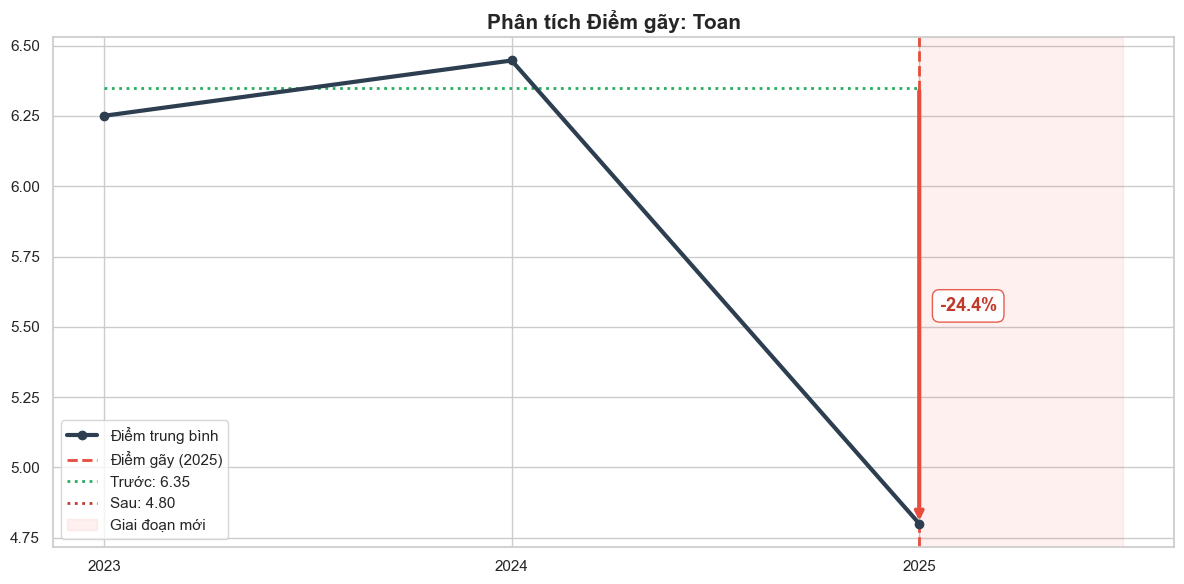

Đang vẽ biểu đồ nâng cao cho: Ngu_Van


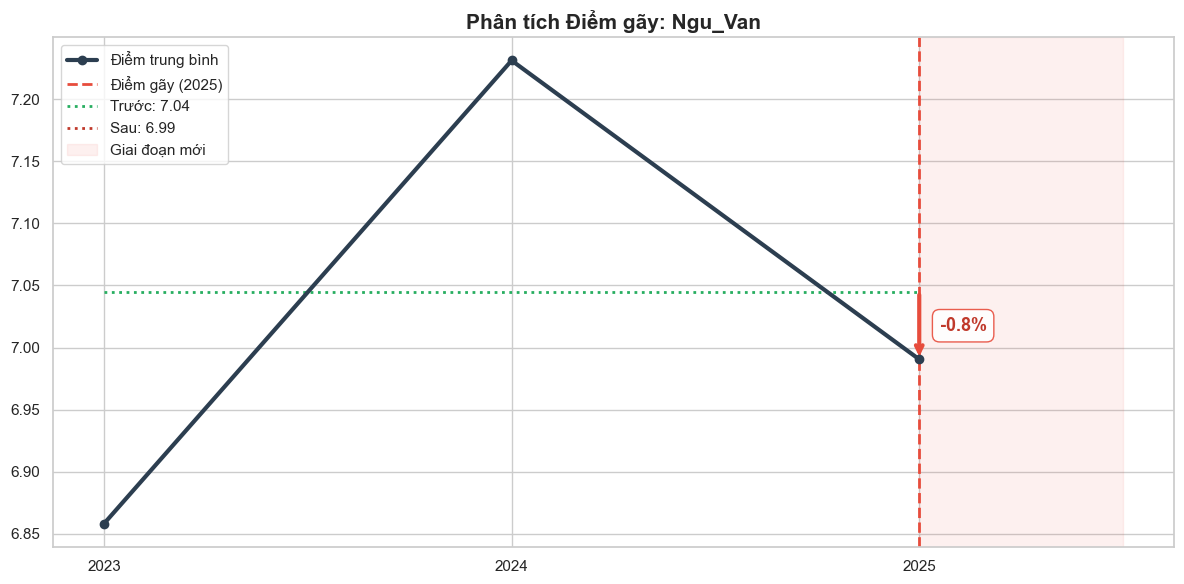

Đang vẽ biểu đồ nâng cao cho: Ngoai_Ngu


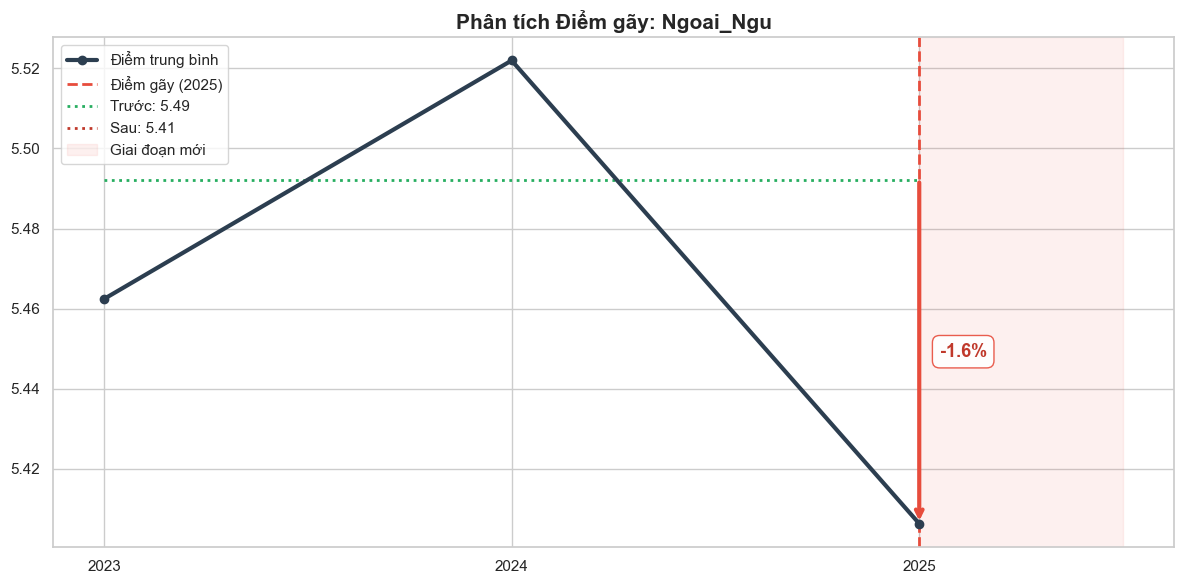

Đang vẽ biểu đồ nâng cao cho: Vat_Li


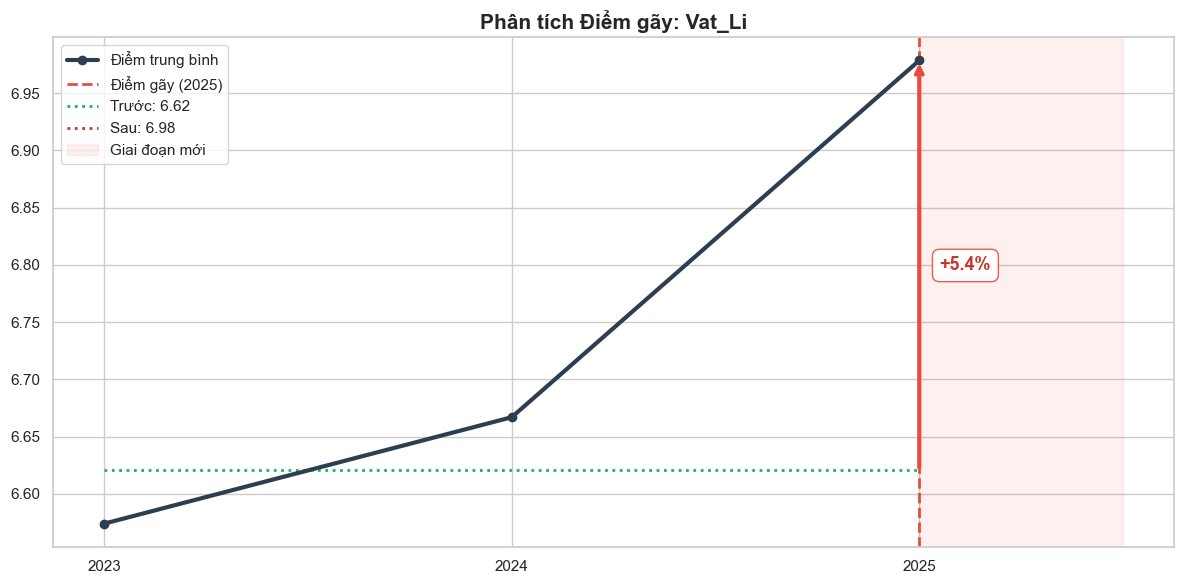

Đang vẽ biểu đồ nâng cao cho: Hoa_Hoc


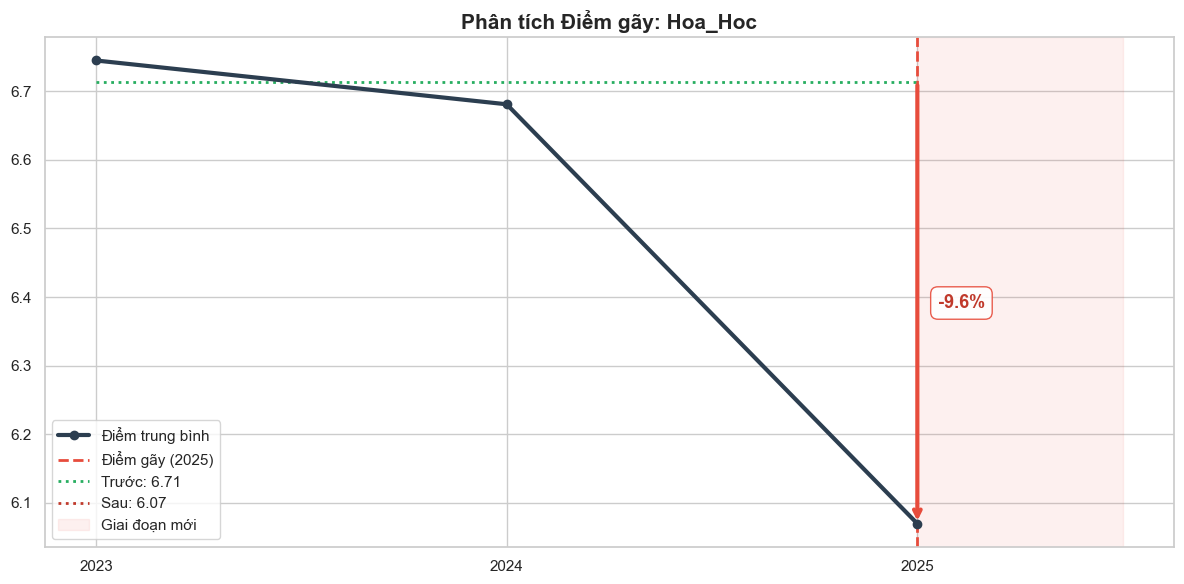

Đang vẽ biểu đồ nâng cao cho: Sinh_Hoc


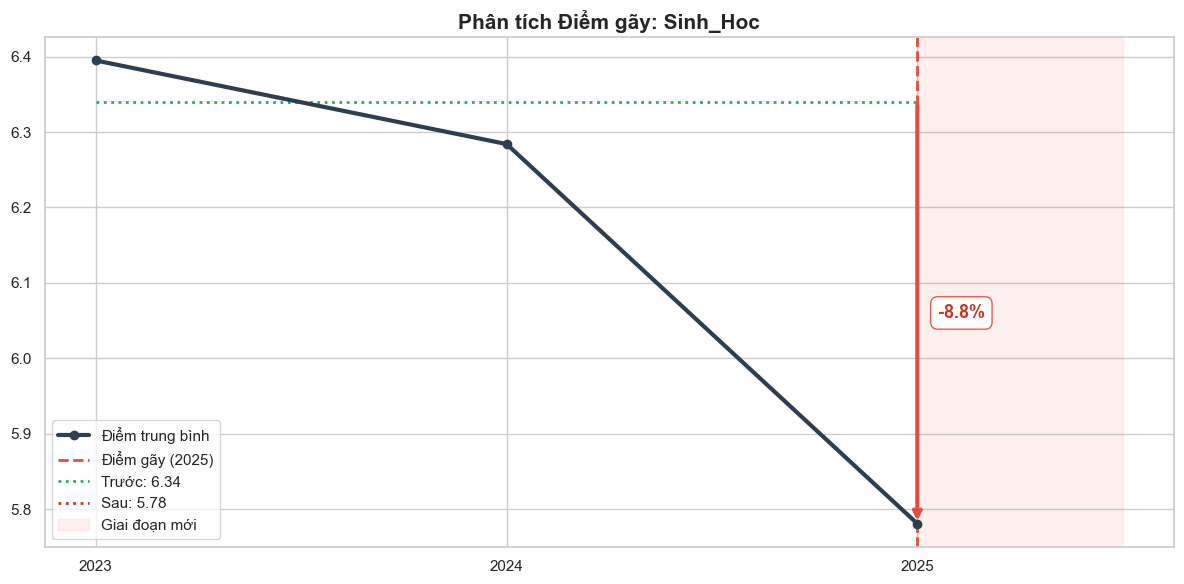

Đang vẽ biểu đồ nâng cao cho: Lich_Su


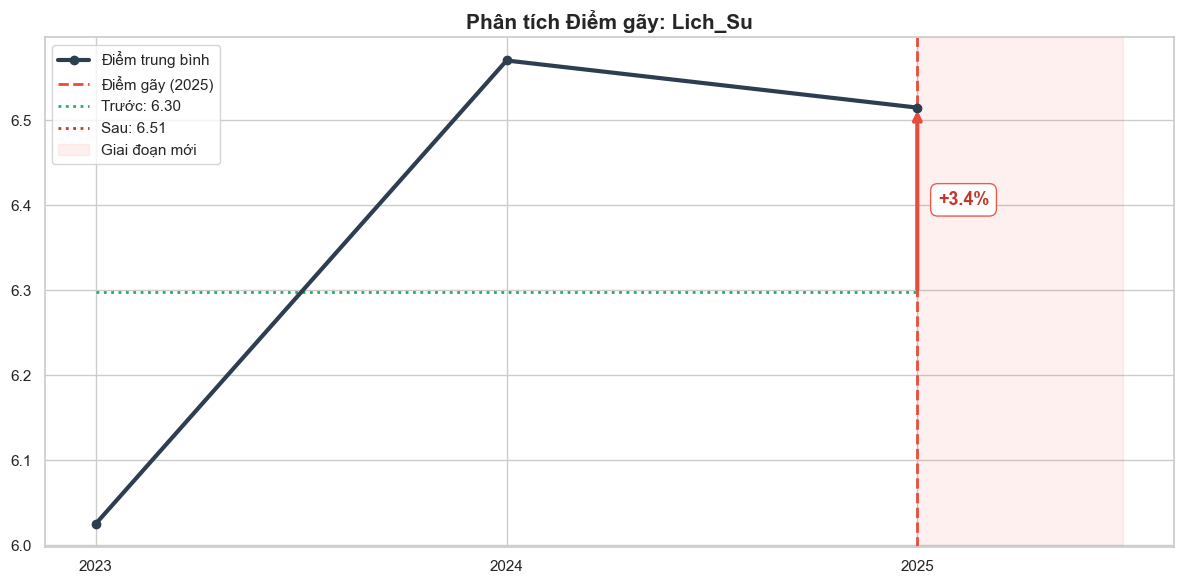

Đang vẽ biểu đồ nâng cao cho: Dia_Li


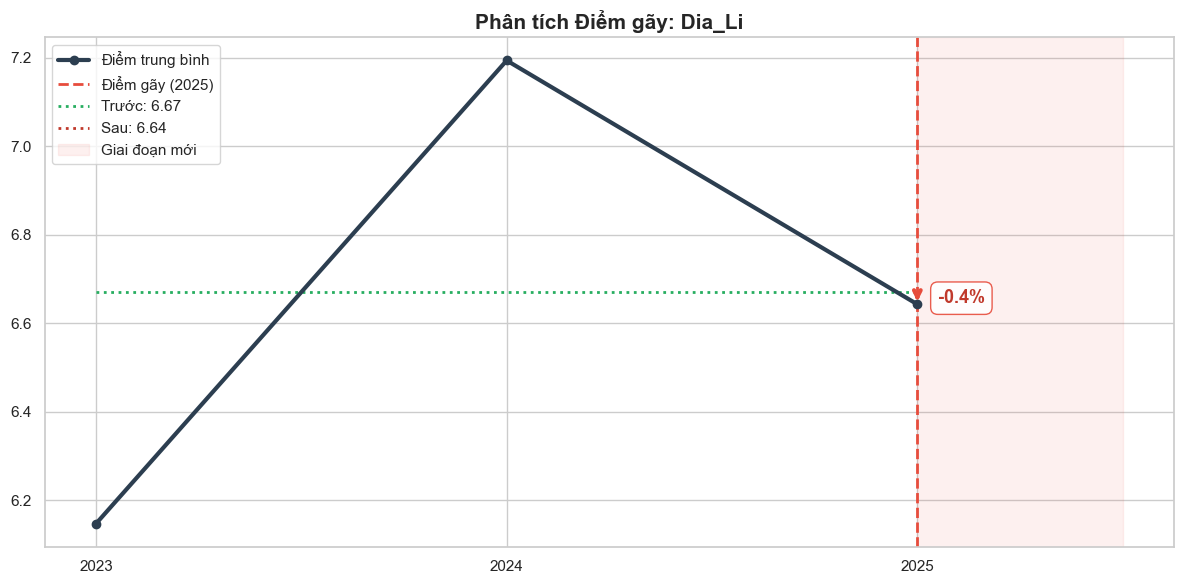

Đang vẽ biểu đồ nâng cao cho: GDCD


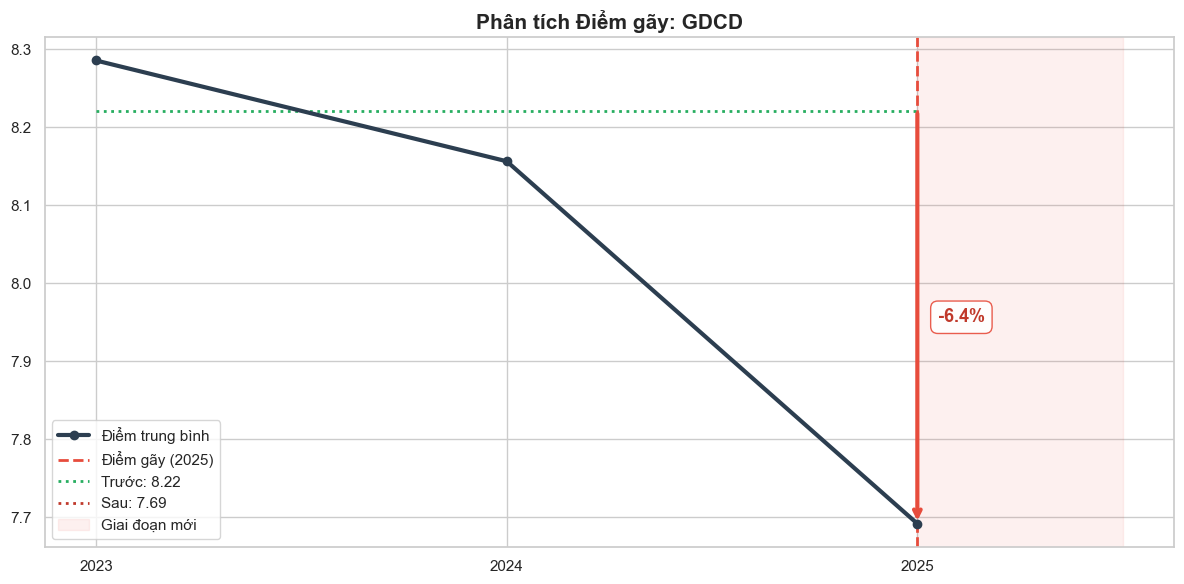

In [6]:
# --- CELL 4: VẼ BIỂU ĐỒ  ---
# Giả sử detector đã chạy và có kết quả
# if 'detector' in locals() and hasattr(detector, 'results'):
#     # Lấy đại một kết quả có điểm gãy để vẽ demo
#     # Ưu tiên lấy môn Toán hoặc Văn nếu có
#     target_series = "Toan"
#     row = detector.results[detector.results['series_id'] == target_series]
    
#     if not row.empty and len(row.iloc[0]['detected_years']) > 0:
#         years = row.iloc[0]['detected_years']
#         print(f"Đang vẽ biểu đồ nâng cao cho: {target_series}")
        
#         # GỌI HÀM MỚI TẠI ĐÂY
#         detector.plot_enhanced(target_series, years)
#     else:
#         # Nếu Toán không gãy, lấy cái đầu tiên tìm được
#         has_break = detector.results[detector.results['detected_years'].apply(len) > 0]
#         if not has_break.empty:
#             s_id = has_break.iloc[0]['series_id']
#             yrs = has_break.iloc[0]['detected_years']
#             detector.plot_enhanced(s_id, yrs)
#         else:
#             print("Chưa tìm thấy điểm gãy nào để vẽ.")


## Vễ biểu đồ phân tích tác động của điểm gãy cho toàn bộ các môn
for s in subjects_list:
    target_series = s
    row = detector.results[detector.results['series_id'] == target_series]
    
    if not row.empty and len(row.iloc[0]['detected_years']) > 0:
        years = row.iloc[0]['detected_years']
        print(f"Đang vẽ biểu đồ nâng cao cho: {target_series}")
        
        # GỌI HÀM MỚI TẠI ĐÂY
        detector.plot_enhanced(target_series, years)
    else:
        # Nếu Toán không gãy, lấy cái đầu tiên tìm được
        has_break = detector.results[detector.results['detected_years'].apply(len) > 0]
        if not has_break.empty:
            s_id = has_break.iloc[0]['series_id']
            yrs = has_break.iloc[0]['detected_years']
            detector.plot_enhanced(s_id, yrs)
        else:
            print("Chưa tìm thấy điểm gãy nào để vẽ.")

## 4. Phân tích điểm gãy (Change Point Analysis)

=== BẢNG TỔNG HỢP CHANGE POINT ===


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,series_id,break_point,mean_pre,mean_post,delta_pct,p_value,significant,cohen_d,magnitude
0,Hoa_Hoc,2025,6.71,6.07,-9.58,0.0316,True,-14.25,Mạnh (Strong)
3,Toan,2025,6.35,4.80,-24.40,0.0404,True,-11.14,Mạnh (Strong)
6,Sinh_Hoc,2025,6.34,5.78,-8.82,0.0629,False,-7.13,Mạnh (Strong)
9,GDCD,2025,8.22,7.69,-6.44,0.0773,False,-5.79,Mạnh (Strong)
12,Vat_Li,2025,6.62,6.98,5.41,0.0822,False,5.45,Mạnh (Strong)
15,Ngoai_Ngu,2025,5.49,5.41,-1.56,0.2125,False,-2.04,Mạnh (Strong)
18,Lich_Su,2025,6.30,6.51,3.44,0.5718,False,0.56,Vừa (Medium)
19,Ngu_Van,2025,7.04,6.99,-0.77,0.8200,False,-0.21,Yếu (Weak)
20,Dia_Li,2025,6.67,6.64,-0.41,0.9664,False,-0.04,Không đáng kể


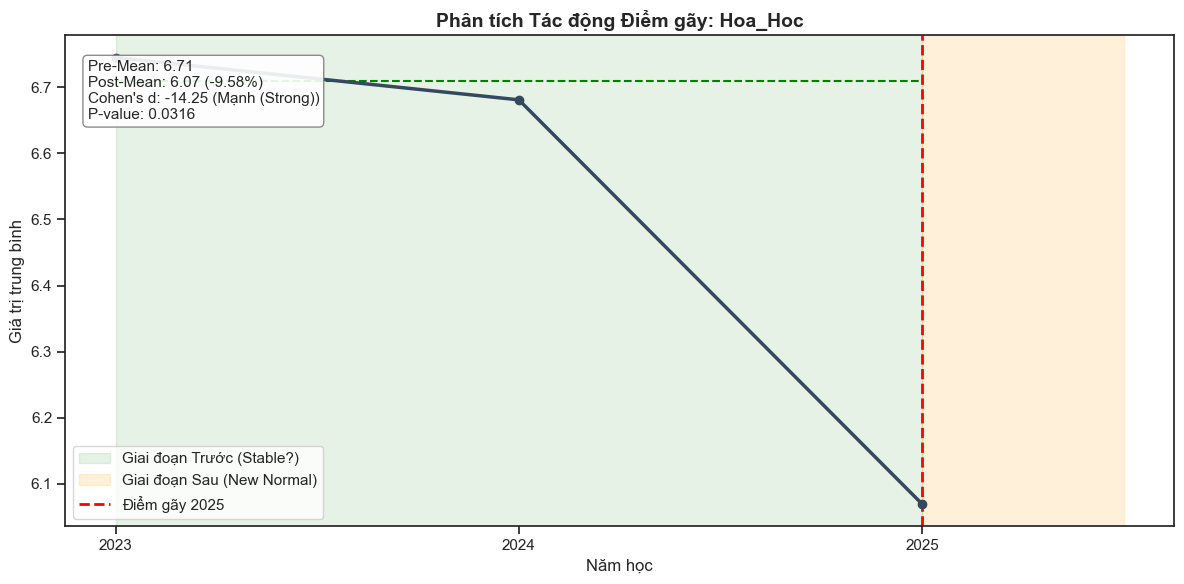

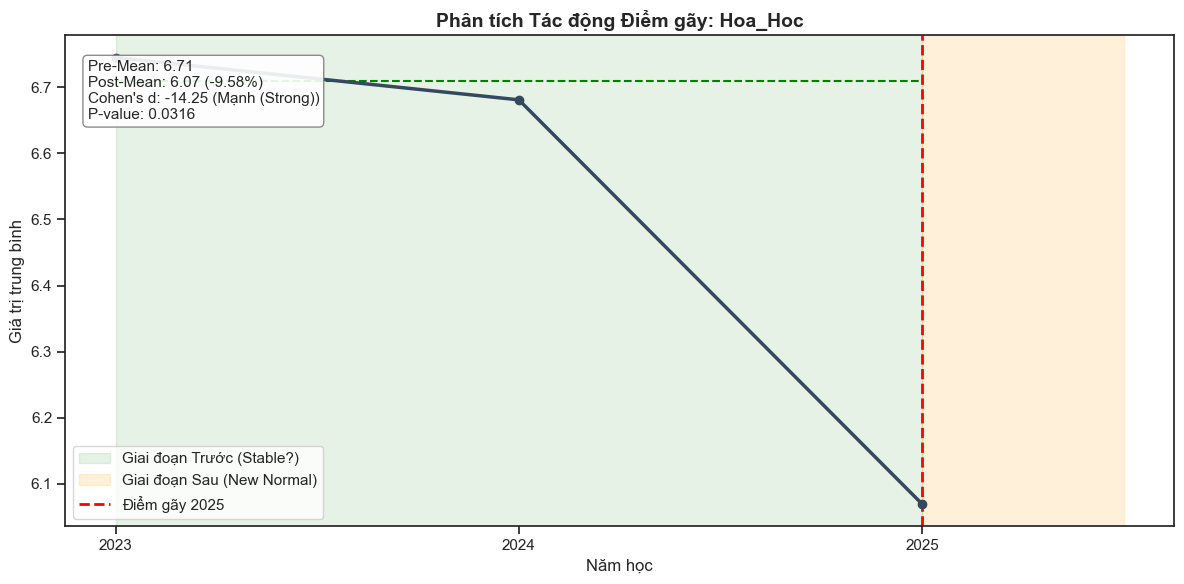

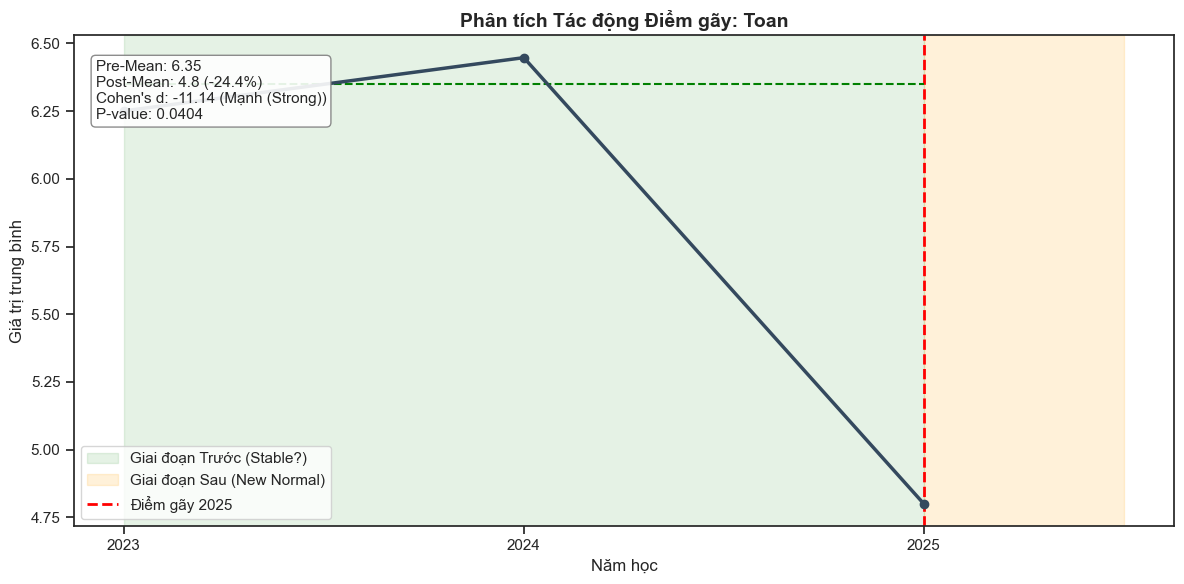

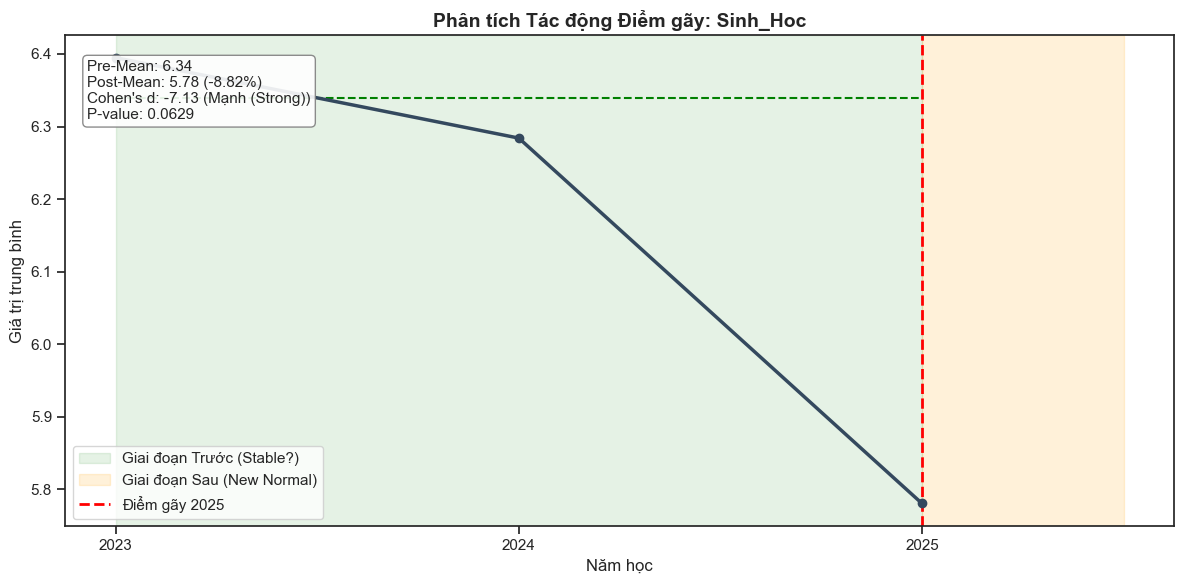

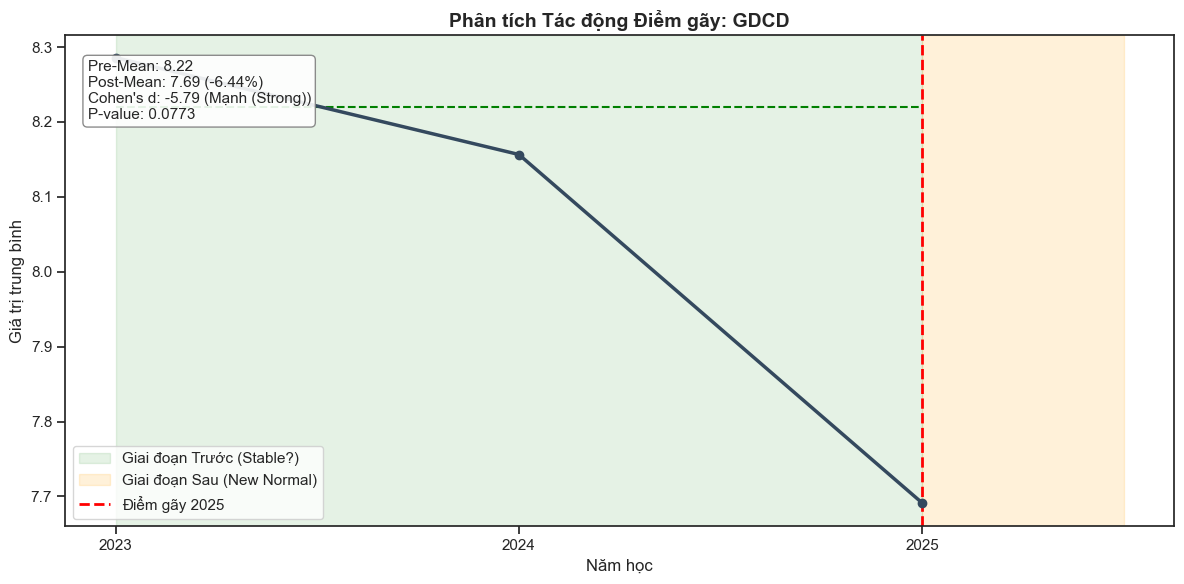

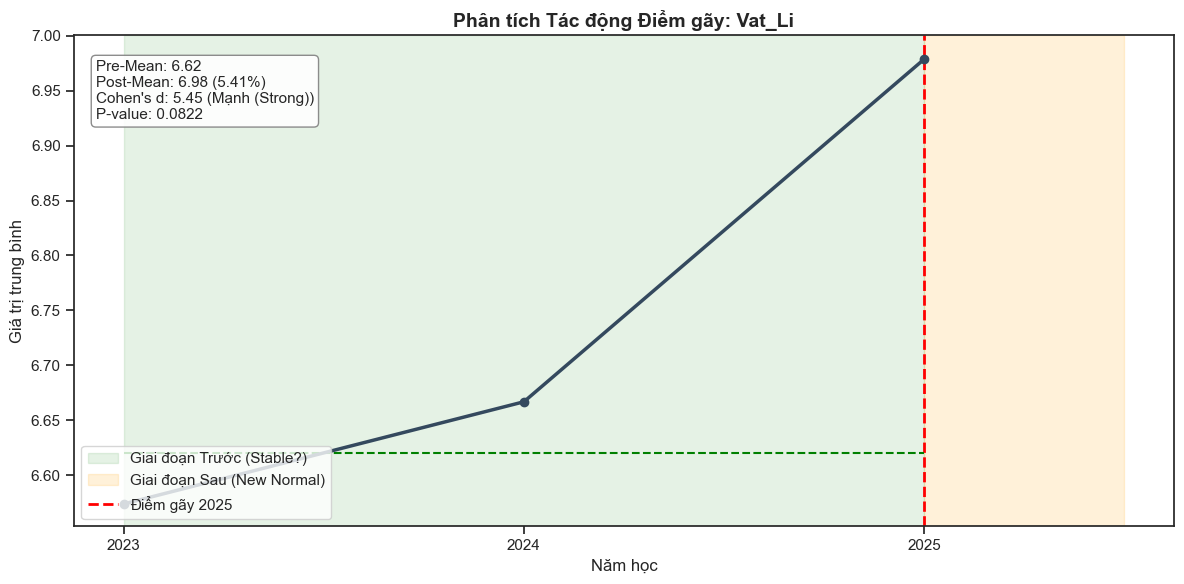

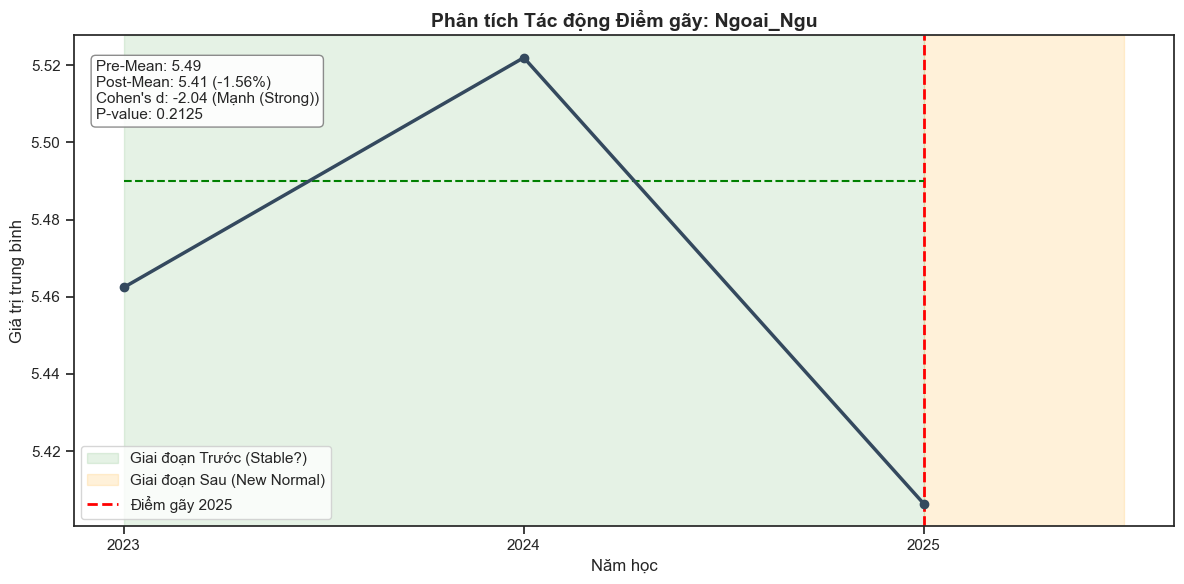

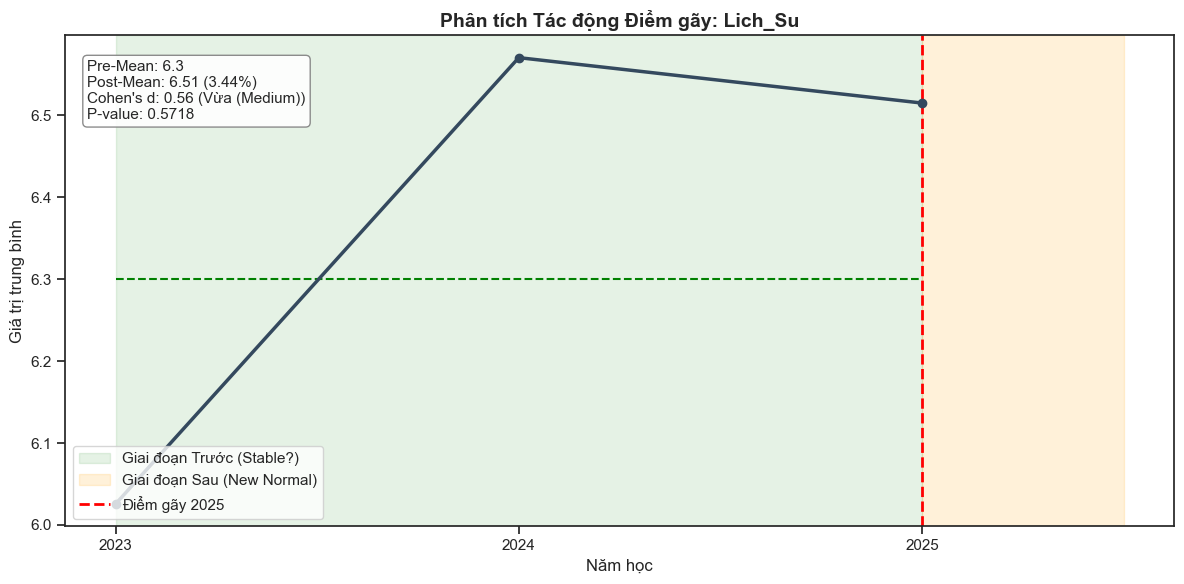

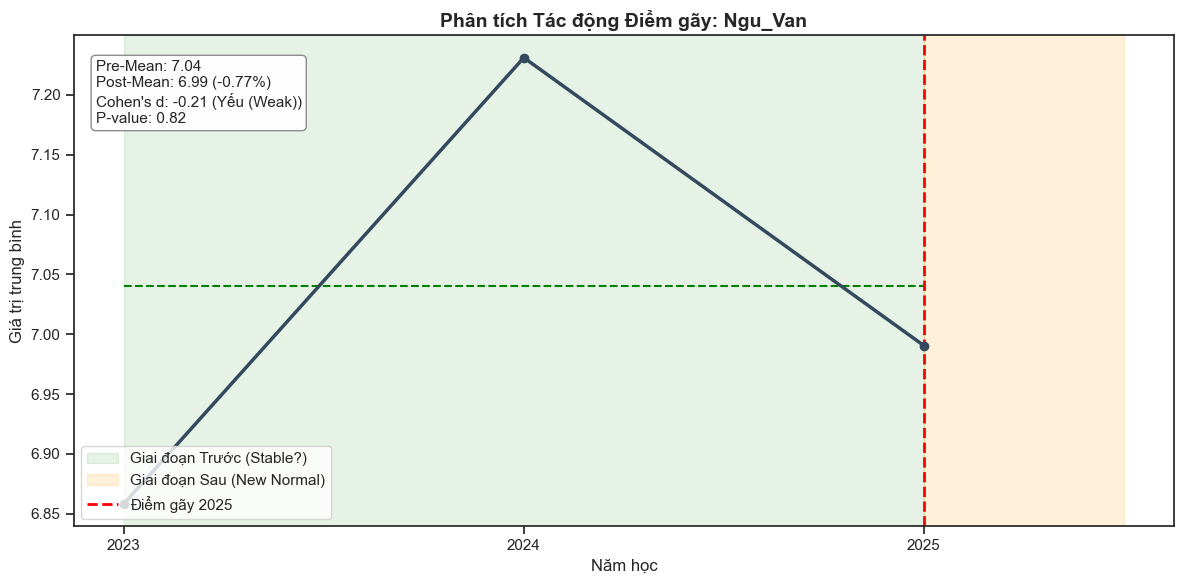

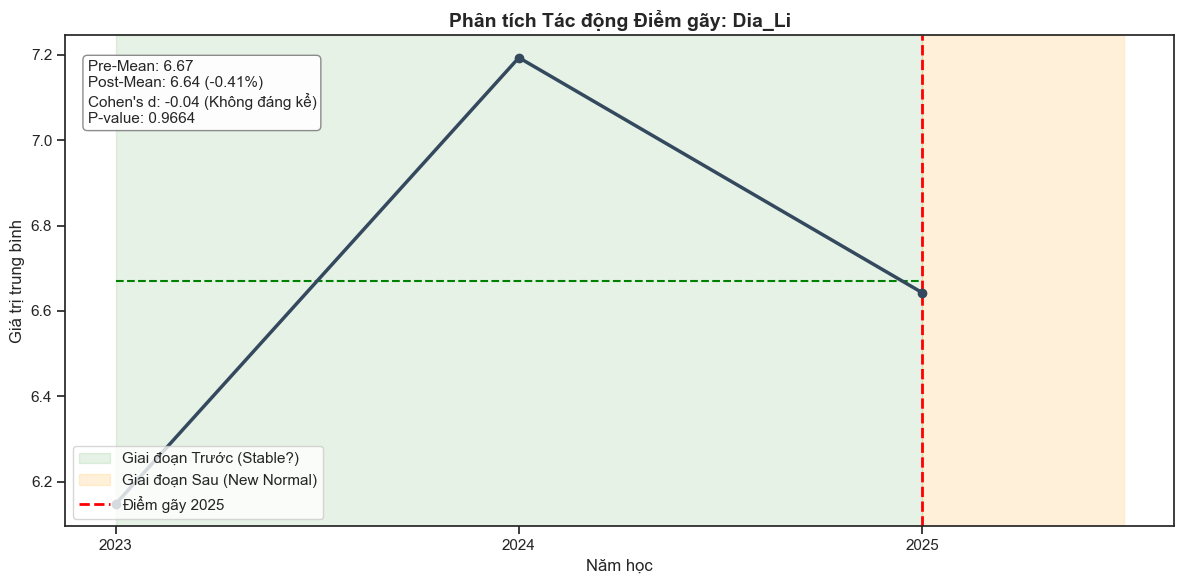

In [7]:
# --- CELL 5: PHÂN TÍCH SÂU VỀ ẢNH HƯỞNG CỦA ĐIỂM GÃY ---
analyzer = ChangePointAnalyzer(df_subjects, target_year=2025)


summary_df = analyzer.analyze_impact(all_results)
# Sắp xếp để cohen's d giảm dần theo giá trị tuyệt đối
summary_df = summary_df.reindex(summary_df['cohen_d'].abs().sort_values(ascending=False).index).reset_index(drop=True)

# Lọc các dòng bị trùng
summary_df = summary_df.drop_duplicates(subset=['series_id'])
# Hiển thị bảng tổng hợp (Input định tính cho dự báo)
print("=== BẢNG TỔNG HỢP CHANGE POINT ===")
display(summary_df) 
# Kết quả sẽ có cột: magnitude (Mạnh/Vừa/Yếu), p_value (có ý nghĩa ko?), delta_pct (% thay đổi)

# Vẽ biểu đồ minh họa cho môn có biến động mạnh nhất
if not summary_df.empty:
    # Lấy môn có Cohen's d lớn nhất
    top_change_series = summary_df.loc[summary_df['cohen_d'].abs().idxmax(), 'series_id']
    analyzer.plot_impact_visual(top_change_series)
    
# Vẽ biểu đồ minh họa cho tất cac môn có điểm gãy không lấy môn trùng
for idx, row in summary_df.iterrows():
    series_id = row['series_id']
    analyzer.plot_impact_visual(series_id)

##  Trực quan hóa (Visualization)
Vẽ biểu đồ minh họa sự thay đổi cấu trúc.

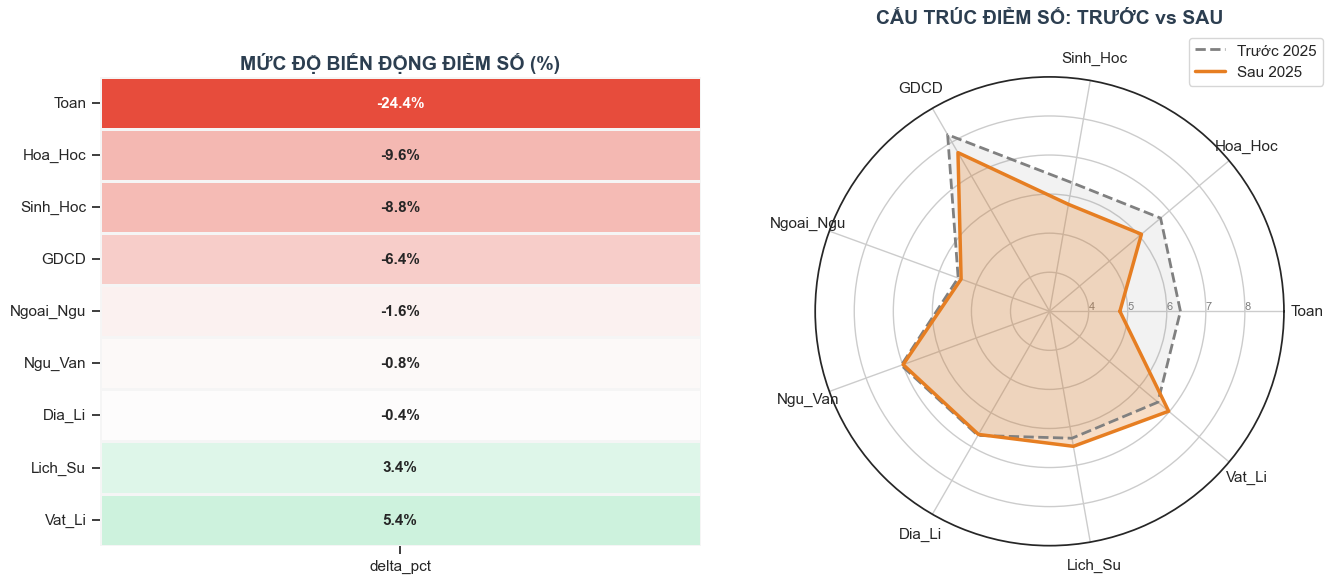

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from math import pi

# 1. Loại bỏ phần tử trùng trong subjects_list và blocks_list
subjects_list = list(set(subjects_list))
blocks_list = list(set(blocks_list))

# 2. Lọc dữ liệu hiển thị (Chỉ lấy Môn học và Khối thi để vẽ cho gọn, bỏ Tỉnh)
# Giả sử series_id của môn/khối không trùng tên tỉnh
focus_ids = subjects_list + blocks_list
df_viz = summary_df[summary_df['series_id'].isin(focus_ids)].copy()

if df_viz.empty:
    print("⚠️ Chưa có kết quả phân tích nào khớp với danh sách môn/khối.")
else:
    # ==========================================
    # PHẦN 1: HEATMAP (MỨC ĐỘ THAY ĐỔI %)
    # ==========================================
    # Loại bỏ các bản sao trong df_viz
    df_viz = df_viz.drop_duplicates(subset=["series_id"])

    # Sắp xếp theo mức độ giảm -> tăng
    df_viz = df_viz.sort_values("delta_pct", ascending=True)
    heat_data = df_viz.set_index("series_id")[["delta_pct"]]

    # Tạo màu: Đỏ (Giảm) -> Trắng (Giữ nguyên) -> Xanh (Tăng)
    cmap = LinearSegmentedColormap.from_list("ExamDiverge", ["#e74c3c", "#fdfefe", "#2ecc71"], N=100)

    plt.figure(figsize=(14, 6))

    # Subplot 1: Heatmap
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(
        heat_data, annot=True, fmt=".1f", cmap=cmap, center=0,
        linewidths=1, linecolor='whitesmoke', cbar=False,
        annot_kws={"size": 11, "weight": "bold"}
    )

    # Thêm dấu %
    for t in ax.texts: t.set_text(t.get_text() + "%")

    plt.title("MỨC ĐỘ BIẾN ĐỘNG ĐIỂM SỐ (%)", fontsize=14, fontweight='bold', color='#2c3e50')
    plt.ylabel("")
    plt.xlabel("")

    # ==========================================
    # PHẦN 2: RADAR CHART (BEFORE vs AFTER)
    # ==========================================
    # Chỉ lấy top các môn học để vẽ Radar cho đỡ rối
    radar_df = df_viz[df_viz['series_id'].isin(subjects_list)].copy()

    if not radar_df.empty:
        # Chuẩn bị dữ liệu Radar
        categories = radar_df['series_id'].tolist()
        N = len(categories)

        # Góc vẽ
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1] # Khép kín vòng tròn

        # Giá trị Pre và Post
        values_pre = radar_df['mean_pre'].tolist()
        values_pre += values_pre[:1]

        values_post = radar_df['mean_post'].tolist()
        values_post += values_post[:1]

        # Subplot 2: Radar
        ax2 = plt.subplot(1, 2, 2, polar=True)

        # Vẽ Before (Nét đứt, màu xám)
        ax2.plot(angles, values_pre, linewidth=2, linestyle='--', color='gray', label='Trước 2025')
        ax2.fill(angles, values_pre, 'gray', alpha=0.1)

        # Vẽ After (Nét liền, màu cam chủ đạo)
        ax2.plot(angles, values_post, linewidth=2.5, linestyle='solid', color='#e67e22', label='Sau 2025')
        ax2.fill(angles, values_post, '#e67e22', alpha=0.25)

        # Trang trí trục
        plt.xticks(angles[:-1], categories, size=11)
        ax2.set_rlabel_position(0)
        plt.yticks([4, 5, 6, 7, 8], ["4", "5", "6", "7", "8"], color="grey", size=8)
        plt.ylim(3, 9) # Giới hạn thang điểm 10

        plt.title("CẤU TRÚC ĐIỂM SỐ: TRƯỚC vs SAU", fontsize=14, fontweight='bold', color='#2c3e50', pad=20)
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.tight_layout()
    plt.show()


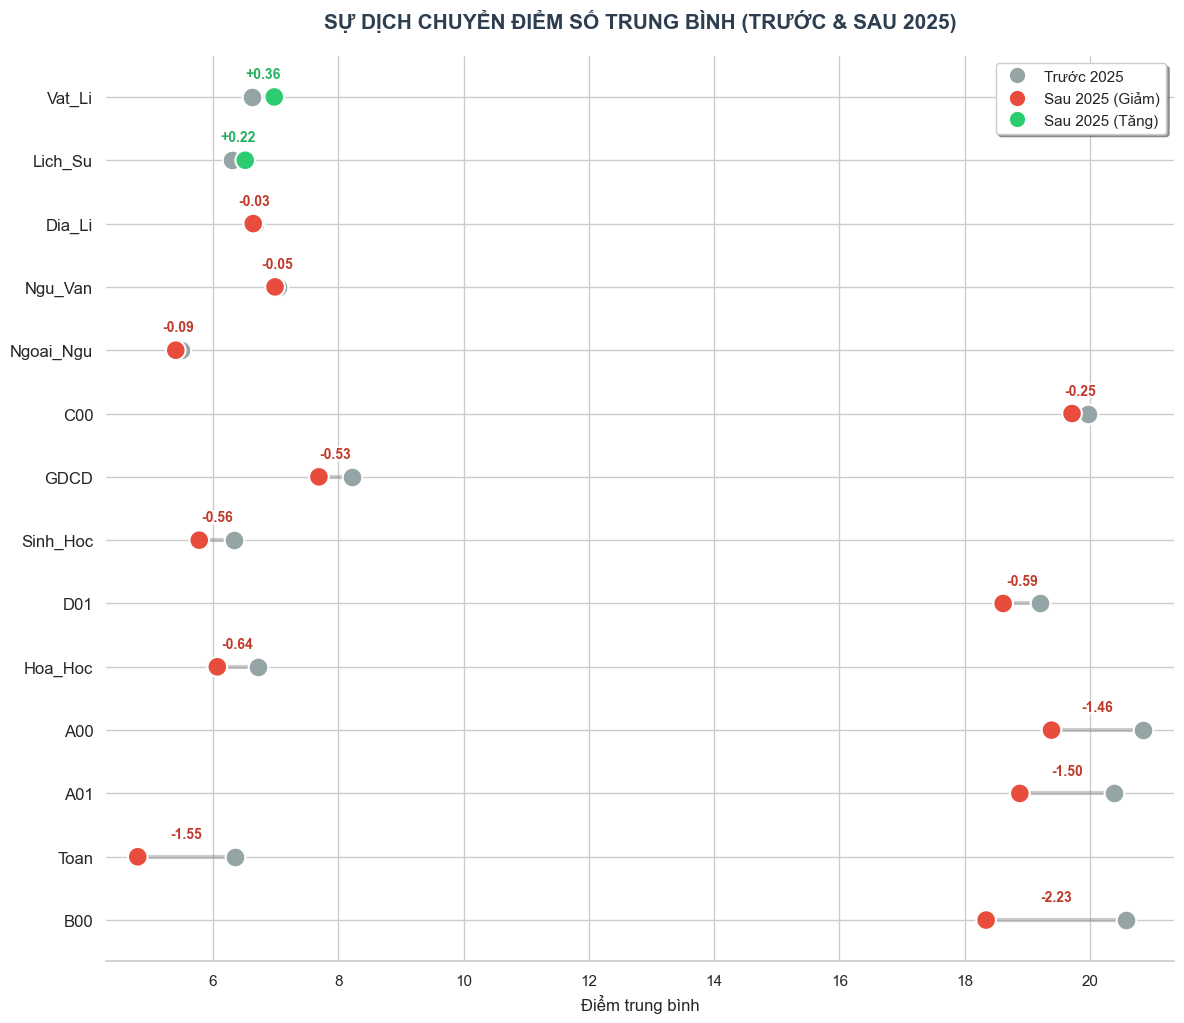

In [9]:
# --- CELL 7: BIỂU ĐỒ DUMBBELL (SỰ DỊCH CHUYỂN ĐIỂM SỐ) ---
# Tự động tính toán lại cho tất cả các môn (kể cả môn không có điểm gãy)
# để đảm bảo đầy đủ dữ liệu trên biểu đồ.

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. CHUẨN BỊ DỮ LIỆU SẠCH (TÍNH TOÁN THỦ CÔNG)
def calculate_pre_post(df_source, target_year=2025):
    """Hàm tính mean trước và sau mốc thời gian cho mọi series"""
    results = []
    if df_source is None or df_source.empty: return pd.DataFrame()
    
    unique_ids = df_source['series_id'].unique()
    
    for sid in unique_ids:
        sub_df = df_source[df_source['series_id'] == sid]
        
        # Tách dữ liệu
        pre_data = sub_df[sub_df['year'] < target_year]['value']
        post_data = sub_df[sub_df['year'] >= target_year]['value']
        
        if len(pre_data) == 0 or len(post_data) == 0:
            continue
            
        mean_pre = pre_data.mean()
        mean_post = post_data.mean()
        
        results.append({
            'Series': sid,
            'Pre_Mean': mean_pre,
            'Post_Mean': mean_post,
            'Diff': mean_post - mean_pre
        })
    return pd.DataFrame(results)

# Gộp dữ liệu môn và khối để vẽ chung
full_source = pd.concat([df_subjects, df_blocks], ignore_index=True)
df_viz = calculate_pre_post(full_source, target_year=2025)

# Sắp xếp theo mức độ giảm điểm nhiều nhất lên đầu (để dễ nhìn)
df_viz = df_viz.sort_values('Diff', ascending=True).reset_index(drop=True)

# 2. VẼ BIỂU ĐỒ (CODE CỦA BẠN ĐÃ ĐƯỢC TINH CHỈNH)
plt.figure(figsize=(12, len(df_viz) * 0.6 + 2)) # Chiều cao linh hoạt theo số lượng môn
sns.set_style("whitegrid")

y_range = range(len(df_viz))

# A. Thanh nối (Dumbbell stick)
plt.hlines(
    y=y_range,
    xmin=df_viz['Pre_Mean'],
    xmax=df_viz['Post_Mean'],
    color='grey',
    alpha=0.4,
    linewidth=3
)

# B. Điểm PRE (Màu xám)
plt.scatter(
    df_viz['Pre_Mean'],
    y_range,
    color='#95a5a6',
    s=200,
    label='Trước 2025',
    zorder=3,
    edgecolors='white',
    linewidth=1.5
)

# C. Điểm POST (Xanh nếu tăng, Đỏ nếu giảm)
colors_post = [
    '#e74c3c' if row['Diff'] < 0 else '#2ecc71'
    for _, row in df_viz.iterrows()
]

plt.scatter(
    df_viz['Post_Mean'],
    y_range,
    color=colors_post,
    s=200,
    label='Sau 2025',
    zorder=4, # Nổi lên trên
    edgecolors='white',
    linewidth=1.5
)

# D. Text chênh lệch (Annotate)
for i, row in df_viz.iterrows():
    diff = row['Diff']
    # Vị trí text nằm giữa đoạn nối
    mid = (row['Pre_Mean'] + row['Post_Mean']) / 2
    
    # Màu chữ
    text_color = '#c0392b' if diff < 0 else '#27ae60'
    
    plt.text(
        mid, i + 0.25, # Nhích lên một chút
        f"{diff:+.2f}", # Format dấu + -
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color=text_color,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5) # Nền trắng mờ để dễ đọc
    )

# E. Trang trí trục
plt.yticks(y_range, df_viz['Series'], fontsize=12, fontweight='500')
plt.xlabel("Điểm trung bình", fontsize=12)
plt.title("SỰ DỊCH CHUYỂN ĐIỂM SỐ TRUNG BÌNH (TRƯỚC & SAU 2025)",
          fontsize=15, fontweight='bold', pad=20, color='#2c3e50')

# Giới hạn trục X để biểu đồ thoáng hơn (Tùy chỉnh nếu cần)
min_val = min(df_viz['Pre_Mean'].min(), df_viz['Post_Mean'].min())
max_val = max(df_viz['Pre_Mean'].max(), df_viz['Post_Mean'].max())
plt.xlim(min_val - 0.5, max_val + 0.5)


# F. Legend (Thủ công)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#95a5a6', markersize=12, label='Trước 2025'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=12, label='Sau 2025 (Giảm)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=12, label='Sau 2025 (Tăng)')
]

plt.legend(handles=legend_elements, loc='upper right', frameon=True, fancybox=True, shadow=True)
sns.despine(left=True, bottom=False)
plt.tight_layout()
plt.show()

In [10]:
!pip install ipywidgets
!pip install jupyterlab

Dropdown(description='Chọn Môn:', index=9, options=('Ngoai_Ngu', 'Toan', 'Sinh_Hoc', 'Lich_Su', 'Ngu_Van', 'Di…

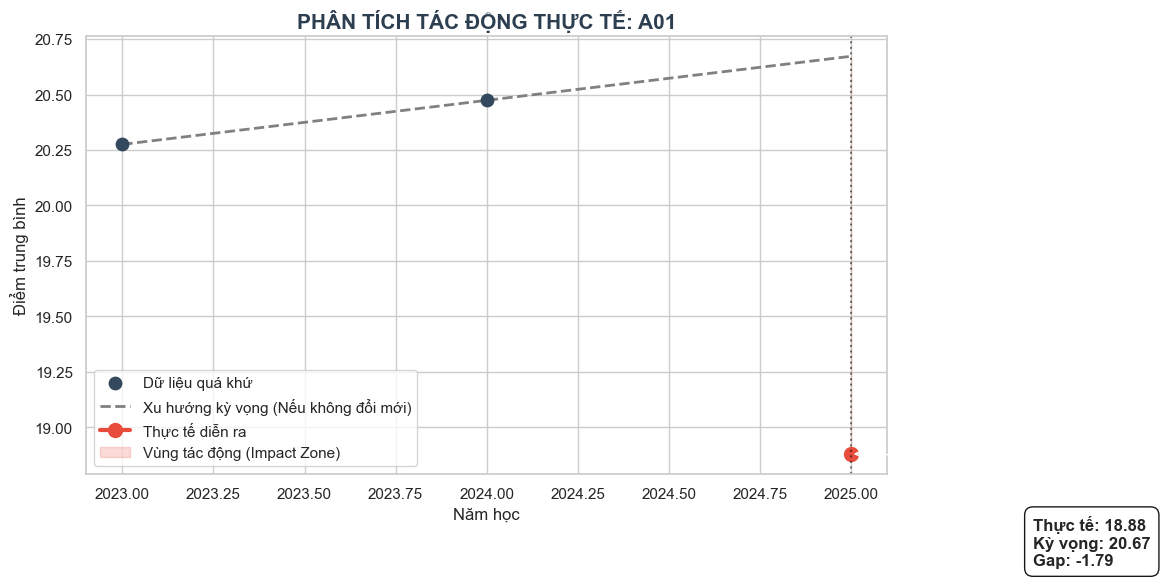

In [11]:
# --- CELL 8: PHÂN TÍCH KỊCH BẢN ĐỐI CHỨNG (COUNTERFACTUAL ANALYSIS) ---


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display, clear_output

# Cấu hình
sns.set_style("whitegrid")

def plot_counterfactual(series_id, break_point=2025):
    # 1. Lấy dữ liệu
    df_sub = df_subjects[df_subjects['series_id'] == series_id].sort_values('year')
    if df_sub.empty:
        df_sub = df_blocks[df_blocks['series_id'] == series_id].sort_values('year')
    
    if df_sub.empty:
        print("Không tìm thấy dữ liệu.")
        return

    years = df_sub['year'].values.reshape(-1, 1)
    values = df_sub['value'].values

    # 2. Tách dữ liệu Train (Trước điểm gãy)
    mask_train = df_sub['year'] < break_point
    X_train = years[mask_train]
    y_train = values[mask_train]

    if len(X_train) < 2:
        print(f"Không đủ dữ liệu quá khứ để dự báo xu hướng cho {series_id}")
        return

    # 3. Train Model (Linear Regression)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 4. Dự báo cho toàn bộ giai đoạn (Quá khứ + Tương lai) để vẽ đường Trend
    # Mở rộng trục thời gian thêm 1 năm sau năm cuối cùng để nhìn cho thoáng
    future_years = np.arange(years.min(), years.max() + 1).reshape(-1, 1)
    y_pred = model.predict(future_years)

    # 5. Tính toán Gap tại năm 2025
    try:
        actual_2025 = df_sub[df_sub['year'] == break_point]['value'].values[0]
        pred_2025 = model.predict([[break_point]])[0]
        gap = actual_2025 - pred_2025
    except IndexError:
        gap = 0
        actual_2025 = 0
        pred_2025 = 0

    # --- VẼ BIỂU ĐỒ ---
    plt.figure(figsize=(12, 6))
    
    # A. Vẽ vùng quá khứ (Dữ liệu dùng để train)
    plt.scatter(X_train, y_train, color='#34495e', s=80, label='Dữ liệu quá khứ', zorder=3)
    
    # B. Vẽ đường Trend dự báo (What-if scenario)
    plt.plot(future_years, y_pred, color='gray', linestyle='--', linewidth=2, label='Xu hướng kỳ vọng (Nếu không đổi mới)')

    # C. Vẽ dữ liệu thực tế sau 2025
    mask_test = df_sub['year'] >= break_point
    plt.plot(years[mask_test], values[mask_test], marker='o', markersize=10, 
             color='#e74c3c', linewidth=3, label='Thực tế diễn ra')

    # D. Tô màu vùng chênh lệch (Impact Zone)
    # Tìm index của năm gãy trong mảng future_years
    idx_start = np.where(future_years == break_point)[0][0]
    
    plt.fill_between(
        future_years[idx_start:].flatten(),
        y_pred[idx_start:].flatten(),
        values[mask_test], # Cần đảm bảo độ dài khớp nhau nếu data thực tế đủ dài
        color='#e74c3c' if gap < 0 else '#2ecc71',
        alpha=0.2,
        label='Vùng tác động (Impact Zone)'
    )

    # E. Annotation (Điểm nhấn)
    plt.annotate(
        f"Thực tế: {actual_2025:.2f}\nKỳ vọng: {pred_2025:.2f}\nGap: {gap:+.2f}",
        xy=(break_point, actual_2025),
        xytext=(break_point + 0.5, actual_2025 + (0.5 if gap > 0 else -0.5)),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.9),
        fontsize=12, fontweight='bold'
    )

    plt.axvline(x=break_point, color='black', linestyle=':', alpha=0.5)
    plt.title(f"PHÂN TÍCH TÁC ĐỘNG THỰC TẾ: {series_id.upper()}", fontsize=15, fontweight='bold', color='#2c3e50')
    plt.xlabel("Năm học")
    plt.ylabel("Điểm trung bình")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- TẠO DROPDOWN MENU ---
dd_counterfactual = widgets.Dropdown(
    options=subjects_list + blocks_list,
    value='Toan',
    description='Chọn Môn:',
    style={'description_width': 'initial'}
)

def on_cf_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(dd_counterfactual)
        plot_counterfactual(change['new'])

dd_counterfactual.observe(on_cf_change)

print("📈 PHÂN TÍCH KỊCH BẢN: THỰC TẾ vs. KỲ VỌNG")
display(dd_counterfactual)

# Vẽ mặc định
plot_counterfactual('Toan')


## 📊 Phân tích Chuyên sâu đối chứng:

Để đánh giá tác động thực sự của kỳ thi 2025, thay vì so sánh đơn thuần, chúng tôi áp dụng kỹ thuật **Counterfactual Analysis** kết hợp **Linear Regression**.

### 1. Phương pháp tiếp cận
Quy trình thực hiện qua 3 bước:
1.  **Model Training:** Học xu hướng tăng trưởng (Trend) từ dữ liệu lịch sử.
2.  **Counterfactual Projection:** Dự báo điểm năm 2025 dựa trên giả định *"Nếu không thay đổi quy chế, điểm số sẽ là bao nhiêu?"* (Đường kỳ vọng).
3.  **Net Impact Assessment:** Đo lường tác động qua chỉ số **Gap**:
    $$Gap = Actual_{2025} - Predicted_{2025}$$

---

### 2. Data-Driven Insights
Từ kết quả định lượng, chúng tôi ghi nhận 3 hiện tượng cốt lõi:

* 🎯 **Hiệu chỉnh Lạm phát điểm (Correction of Grade Inflation):**
    Hiện tượng **Negative Gap** ($Actual < Predicted$) xuất hiện đồng pha. Kỳ thi 2025 đóng vai trò như một **"chiếc phanh" (brake)**, cắt đứt đà tăng điểm theo quán tính của các năm trước và đưa điểm số về giá trị thực.

* 🎯 **Độ nhạy theo đặc thù môn (Sensitivity Analysis):**
    * **Môn Toán (Gap giảm sâu nhất):** Cho thấy độ nhạy cực cao với format trắc nghiệm mới (Đúng/Sai, Trả lời ngắn), triệt tiêu hiệu quả các chiến thuật "khoanh bừa".
    * **Môn Ngoại Ngữ (Gap nhỏ):** Cho thấy tính bền vững của năng lực ngôn ngữ, ít chịu ảnh hưởng bởi thay đổi cấu trúc đề.

* 🎯 **Điểm gãy cấu trúc (Structural Break):**
    Năm 2025 chính thức thiết lập một **"New Normal"** (Trạng thái bình thường mới). Vùng chênh lệch (Gap) chính là lượng **"năng lực ảo"** đã bị lọc bỏ, giúp dữ liệu có độ phân hóa cao hơn cho công tác tuyển sinh.